In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from tensorflow.keras.datasets import mnist
import warnings

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state

plt.rcParams.update({'font.size': 12})
warnings.simplefilter('ignore')

2024-05-09 10:51:03.882232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 10:51:05.455221: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 3層NN

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape([-1, 784]).astype('float32') / 255
test_images = test_images.reshape([-1, 784]).astype('float32') / 255

train_index = np.where((train_labels == 0) | (train_labels == 1))[0]
test_index = np.where((test_labels == 0) | (test_labels == 1))[0]

train_images = train_images[train_index]
train_labels = train_labels[train_index].reshape([-1, 1])

test_images = test_images[test_index]
test_labels = test_labels[test_index].reshape([-1, 1])

In [3]:
def create_batches(data, batch_size):
    num_batches, mod = divmod(len(data), batch_size) # divmod(a,b):a/bの割り算の商とあまりを取得
    data_batched = np.split(data[:num_batches * batch_size], num_batches)
    if mod:
        data_batched.append(data[num_batches * batch_size:])
    data_batched = [jnp.asarray(x) for x in data_batched]
    return data_batched

In [4]:
class SoftmaxEstimationModel(nn.Module):
    @nn.compact
    def __call__(self, x, get_logits=False):
        x = nn.Dense(features=512)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        if get_logits:
            return x
        x = nn.softmax(x)
        return x

In [5]:
key, key1 = random.split(random.PRNGKey(0))
variables = SoftmaxEstimationModel().init(key1, train_images[0:1])

jax.tree_util.tree_map(lambda x: x.shape, variables['params'])

'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring f

{'Dense_0': {'bias': (512,), 'kernel': (784, 512)},
 'Dense_1': {'bias': (1,), 'kernel': (512, 1)}}

In [6]:
state = train_state.TrainState.create(
    apply_fn = SoftmaxEstimationModel().apply,
    params = variables['params'],
    tx = optax.adam(learning_rate=0.001)
)

'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)


In [7]:
@jax.jit
def train_step(state, inputs, labels):
    # loss以外も返す場合はhas_aux=True
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(
        state.params,
        state,
        inputs,
        labels
    )
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, acc

In [8]:
@jax.jit
def loss_fn(params, state, inputs, labels):
    logits = state.apply_fn({'params': params}, inputs, get_logits=True)
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = jnp.mean(jnp.sign(logits) == jnp.sign(labels-0.5))
    return loss, acc

In [9]:
def train_epoch(state, input_batched, label_batched, eval):
    loss_history, acc_history = [], []
    for inputs, labels in zip(input_batched, label_batched):
        new_state, loss, acc = train_step(state, inputs, labels)
        if not eval:
            state = new_state
        loss_history.append(jax.device_get(loss).tolist())
        acc_history.append(jax.device_get(acc).tolist())
    return state, np.mean(loss_history), np.mean(acc_history)

In [10]:
def fit(state, train_inputs, train_labels, test_inputs, test_labels, epochs, batch_size):
    train_inputs_batched = create_batches(train_inputs, batch_size)
    train_labels_batched = create_batches(train_labels, batch_size)
    test_inputs_batched = create_batches(test_inputs, batch_size)
    test_labels_batched = create_batches(test_labels, batch_size)

    loss_history_train, acc_history_train = [], []
    loss_history_test, acc_history_test = [], []

    for epoch in range(1, epochs+1):
        # Train
        state, loss_train, acc_train = train_epoch(state, train_inputs_batched, train_labels_batched, eval=False)
        loss_history_train.append(loss_train)
        acc_history_train.append(acc_train)

        # Eval
        _, loss_test, acc_test = train_epoch(state, test_inputs_batched, test_labels_batched, eval=True)
        loss_history_test.append(loss_test)
        acc_history_test.append(acc_test)

        print ('Epoch: {}, Loss: {:.4f}, Accuracy {:.4f}'.format(epoch, loss_train, acc_train), flush=True, end='')
        print (' Test: Loss: {:.4f}, Accuracy {:.4f}'.format(loss_test, acc_test), flush=True)

    history = {'loss_train': loss_history_train,
           'acc_train': acc_history_train,
           'loss_test': loss_history_test,
           'acc_test': acc_history_test}

    return state, history

In [11]:
%%time
state, history = fit(state, train_images, train_labels, test_images, test_labels, epochs=16, batch_size=128)

'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)


Epoch: 1, Loss: 0.0268, Accuracy 0.9947 Test: Loss: 0.0022, Accuracy 0.9995


'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)
'+ptx84' is not a recognized feature for this target (ignoring feature)


Epoch: 2, Loss: 0.0030, Accuracy 0.9991 Test: Loss: 0.0018, Accuracy 0.9995
Epoch: 3, Loss: 0.0019, Accuracy 0.9994 Test: Loss: 0.0017, Accuracy 0.9995
Epoch: 4, Loss: 0.0011, Accuracy 0.9997 Test: Loss: 0.0021, Accuracy 0.9995
Epoch: 5, Loss: 0.0007, Accuracy 0.9998 Test: Loss: 0.0019, Accuracy 0.9995
Epoch: 6, Loss: 0.0004, Accuracy 1.0000 Test: Loss: 0.0016, Accuracy 0.9995
Epoch: 7, Loss: 0.0002, Accuracy 1.0000 Test: Loss: 0.0014, Accuracy 0.9995
Epoch: 8, Loss: 0.0002, Accuracy 1.0000 Test: Loss: 0.0014, Accuracy 0.9991
Epoch: 9, Loss: 0.0001, Accuracy 1.0000 Test: Loss: 0.0014, Accuracy 0.9991
Epoch: 10, Loss: 0.0001, Accuracy 1.0000 Test: Loss: 0.0014, Accuracy 0.9991
Epoch: 11, Loss: 0.0001, Accuracy 1.0000 Test: Loss: 0.0013, Accuracy 0.9991
Epoch: 12, Loss: 0.0001, Accuracy 1.0000 Test: Loss: 0.0013, Accuracy 0.9991
Epoch: 13, Loss: 0.0001, Accuracy 1.0000 Test: Loss: 0.0013, Accuracy 0.9991
Epoch: 14, Loss: 0.0000, Accuracy 1.0000 Test: Loss: 0.0013, Accuracy 0.9991
Epoch: 

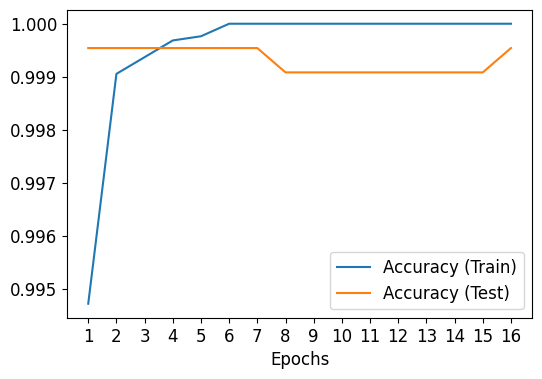

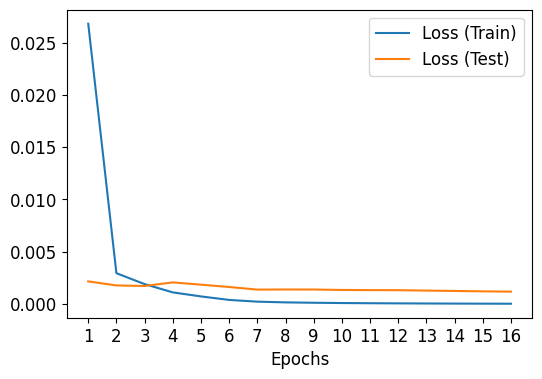

In [12]:

df = DataFrame({'Accuracy (Train)': history['acc_train'],
                'Accuracy (Test)': history['acc_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'Loss (Train)': history['loss_train'],
                'Loss (Test)': history['loss_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)